## Imports

In [35]:
import numpy as np
import einops
import copy
import matplotlib
import matplotlib.pyplot as plt


from scipy.spatial import ckdtree
from scipy.optimize import minimize
from scipy.optimize import LinearConstraint

from shapely.geometry.polygon import Polygon
import shapely
from shapely import affinity

import importlib
import pickle
from datetime import datetime

In [36]:
import bonds
import lattice
import utils
import plot_utils

In [37]:
bonds = importlib.reload(bonds)
lattice = importlib.reload(lattice)
utils = importlib.reload(utils)
plot_utils = importlib.reload(plot_utils)


## Set up lattice

### Kagome bow tie

In [38]:
# lattice params for kagome lattice
nx = 8
ny = 8
grid_params = {'x1':0, 'x2':nx, 'y1':0, 'y2':ny, 'Nx':nx, 'Ny':ny, 
               'a1':np.array([2,0]), 'a2':np.array([1, np.sqrt(3)]), 'O':(0., 0.),
               'unit_cell_bases':[np.array([1/2, 0]), np.array([-1/2, 0]), np.array([0, np.sqrt(3)/2.])]  
                                 }
mesh = lattice.create_grid_mesh(grid_params)
BZ_kpoints = lattice.create_grid(grid_params)
my_x, my_y = zip((BZ_kpoints[:, 0], BZ_kpoints[:, 1]))

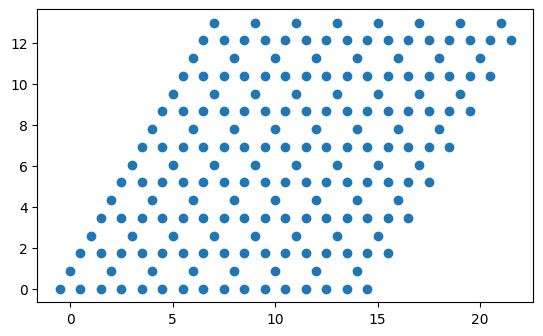

In [39]:
fig, ax = plt.subplots(1,1)
my_x, my_y = lattice.convert_to_XY(BZ_kpoints)
ax.scatter(my_x, my_y)
ax.set_aspect("equal")

In [40]:
height = np.sqrt(3)/2
# polygon = lattice.create_hexagon(5.1, 7, 5 * height)
polygon = lattice.create_hexagon(7.1, 10, 7 * height)
LatticeSpecs = lattice.Lattice(
    a1=np.array([2,0]),
    a2=np.array([1, np.sqrt(3)]),
    unit_cell_bases=[np.array([0.0, 0.0])], 
    lattice_type='kagome', 
    polygon=polygon, 
)

# ebSpecs = bonds.Bonds(
#     polygon_ebs = [
#         polygon, polygon, polygon, polygon, polygon, polygon
#     ], 
#     unit_cell_bases_ebs = [
#         np.array([0, height]), 
#         np.array([1.5, 0.]),
#         np.array([0.5, 0.]),
#         np.array([0., height]),
#         np.array([-0.5, 0.]),
#         np.array([0.5, 0.]),
#     ]    
# )

ebSpecs = bonds.Bonds(
    polygon_ebs = [
        polygon, polygon, polygon, polygon, 
    ], 
    unit_cell_bases_ebs = [
        np.array([0, height]), 
        np.array([1.5, 0.]),
        np.array([0.5, 0.]),
        np.array([0.5, 0.]), 
    ]    
)

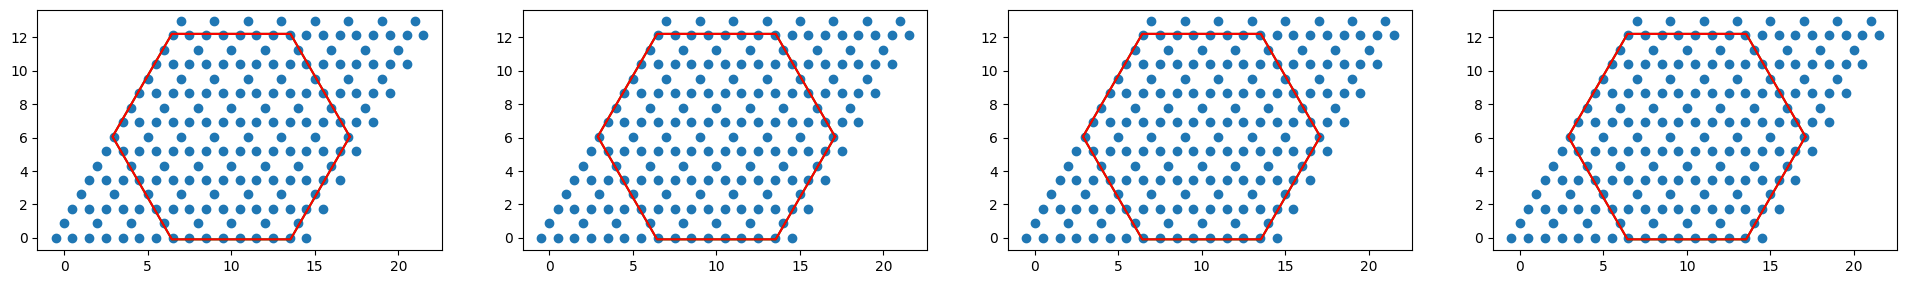

In [41]:
num_configs_loop = len(ebSpecs.polygon_ebs)
fig, axes = plt.subplots(1, num_configs_loop, figsize=(6 *num_configs_loop, 8))
for i, ax in enumerate(axes):
    ax = axes[i]
    my_x, my_y = lattice.convert_to_XY(BZ_kpoints)
    ax.scatter(my_x, my_y)
    ax.set_aspect("equal")
    x,y = polygon.exterior.xy
    polygon2 = ebSpecs.polygon_ebs[i]
    x2,y2 = polygon2.exterior.xy
    ax.plot(x,y, c='g', label="cut boundary")
    ax.plot(x2,y2, c='r', label="cut boundary")

In [42]:
BZ_kpoints_cut = lattice.get_contained_pts_poly(BZ_kpoints, polygon)

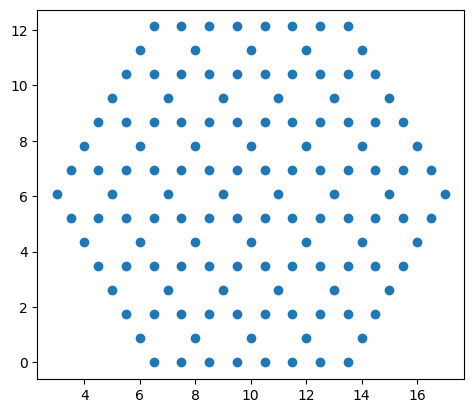

In [43]:
fig, ax = plt.subplots(1,1)
my_x, my_y = lattice.convert_to_XY(BZ_kpoints_cut)
ax.scatter(my_x, my_y)
ax.set_aspect("equal")

Text(0.5, 0.98, 'Lattice with N=132 and $N_{\\rm bonds}=$240')

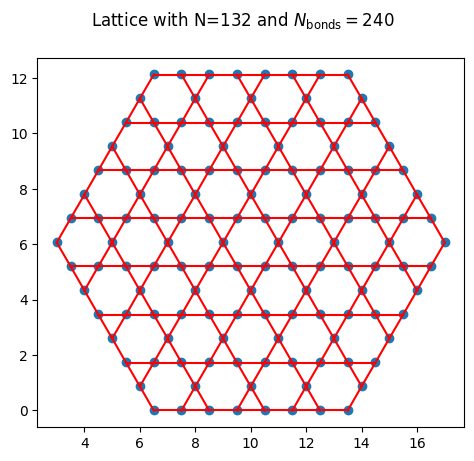

In [44]:
bonds_nn = bonds._find_all_bonds(BZ_kpoints_cut)
fig, ax = plt.subplots(1,1)
# my_x, my_y = zip((np.stack(BZ_kpoints_cut, 0)[:, 0], np.stack(BZ_kpoints_cut, 0)[:, 1]))
ax.scatter(my_x, my_y)
# ax.scatter(*bonds_mid.T, marker='D', c='b')
ax.set_aspect("equal")
plot_utils._plot_v_bonds(ax, bonds_nn, c='r')
fig.suptitle(f"Lattice with N={my_x[0].shape[0]} and " +r"$N_{\rm bonds}=$" + f"{bonds_nn.shape[0]}")


In [45]:
#@title get rydberg bonds
ryd_bonds_indices = bonds._get_ryd_bonds(bonds_nn, [(0.5 + 0.1, 0.), (height+0.01, 0.6), (1.1, height+0.01) ])
print(f" indices are {[ryd_bonds_indices[i].shape for i in range(len(ryd_bonds_indices))]}")
ryd_bonds = [bonds_nn[indices] for indices in ryd_bonds_indices]   #[(M, 2, 2, 2) array for each bond type] each term has 2 bonds
print(f" bonds shape are {[ryd_bonds[i].shape for i in range(len(ryd_bonds))]}")

 indices are [(216, 2), (222, 2), (216, 2)]
 bonds shape are [(216, 2, 2, 2), (222, 2, 2, 2), (216, 2, 2, 2)]


Text(0.5, 0.98, 'Rydberg blockade bonds for 5 random bonds and 3 nn-bond types')

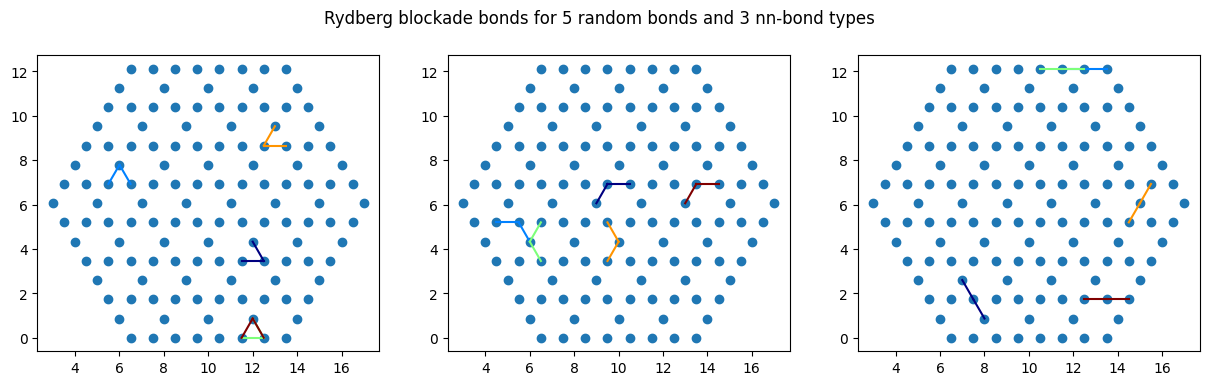

In [46]:
fig, axes = plt.subplots(1, len(ryd_bonds), figsize=(5 * len(ryd_bonds), 4))
my_x, my_y = lattice.convert_to_XY(BZ_kpoints_cut)
num_rand = 5
colors = plt.cm.jet(np.linspace(0, 1, num_rand))

for k, k_bonds in enumerate(ryd_bonds):
    rand_idx = np.random.randint(0, k_bonds.shape[0], num_rand) # generate random indices to plot
    ax = axes[k]
    ax.scatter(my_x, my_y)
    ax.set_aspect("equal")    
    
    for i, j in enumerate(rand_idx):
        # print(i, j)
        # print(f"k vonds shape is {k_bonds.shape}")
        plot_utils._plot_v_bonds(ax, k_bonds[j, ], c=colors[i, ])

plt.suptitle(f"Rydberg blockade bonds for {num_rand} random bonds and {len(ryd_bonds)} nn-bond types")



In [47]:
ListEB_comb = bonds.get_elementaryLoops((nx, ny), 'na', LatticeSpecs, ebSpecs)
ListEBs = sum(ListEB_comb, [])
num_ebs_list = [len(ebs) for ebs in ListEB_comb]
total_num_EBs = len(ListEBs)

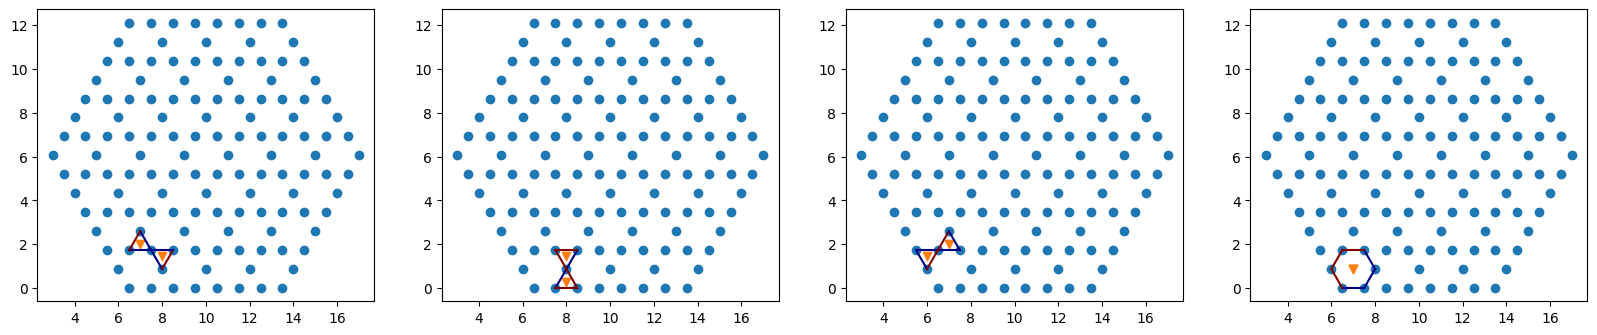

In [48]:
num_config_loops = len(ebSpecs.unit_cell_bases_ebs)
fig, axes = plt.subplots(1,num_config_loops, figsize = (num_config_loops * 5, 5 * 1), squeeze=False)

for i, ebs in enumerate(ListEB_comb):
  ax = axes[0, i]
  ax.scatter(my_x, my_y)
  for j, eb in enumerate(ebs[:1]):
    triangles = np.split(eb['triangles'], 2, axis=1)
    bd_vs = eb['bd_vs']
    # print(bd_vs.shape)
    mid_vs = eb['mid_vs']
    bd_signs = eb['bd_signs']
    
    colors = plt.cm.jet(np.linspace(0,1,2))
    bd_signs_idx = ((bd_signs + 1.)/2).astype(int)
    # print(bd_signs_idx)
    c = colors[bd_signs_idx]
    ax.scatter(triangles[0], triangles[1], marker='v')
    plot_utils._plot_v_bonds(ax, bd_vs, c=c)
#     plot_utils._plot_v_bonds(ax, mid_vs, c='r')
    ax.set_aspect("equal")

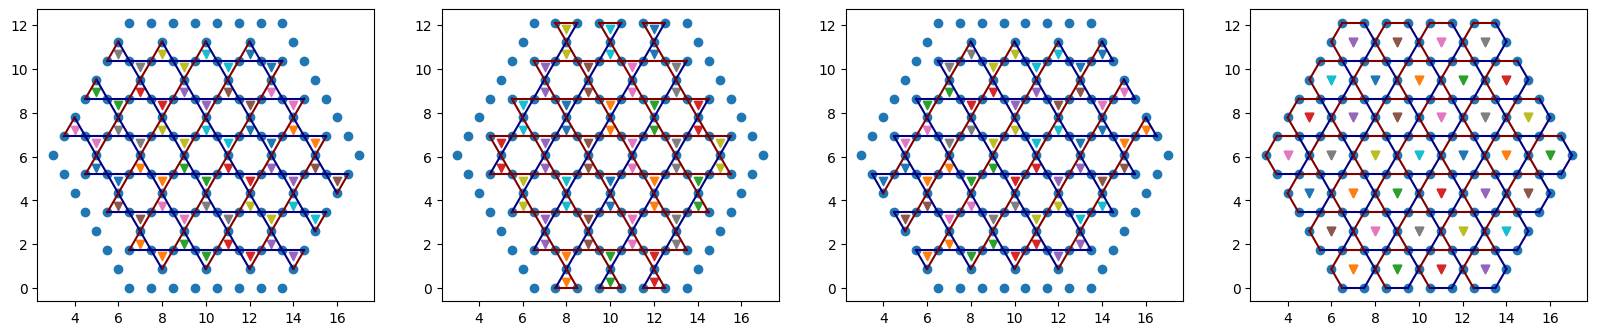

In [49]:
fig, axes = plt.subplots(1,num_config_loops, figsize = (num_config_loops * 5, 5 * 1), squeeze=False)

for i, ebs in enumerate(ListEB_comb):
  ax = axes[0, i]
  ax.scatter(my_x, my_y)
  for j, eb in enumerate(ebs):
    triangles = np.split(eb['triangles'], 2, axis=1)
    bd_vs = eb['bd_vs']
    # print(bd_vs.shape)
    mid_vs = eb['mid_vs']
    bd_signs = eb['bd_signs']
    
    colors = plt.cm.jet(np.linspace(0,1,2))
    bd_signs_idx = ((bd_signs + 1.)/2).astype(int)
    # print(bd_signs_idx)
    c = colors[bd_signs_idx]
    ax.scatter(triangles[0], triangles[1], marker='v')
    plot_utils._plot_v_bonds(ax, bd_vs, c=c)
#     plot_utils._plot_v_bonds(ax, mid_vs, c='r')
    ax.set_aspect("equal")

Text(0.5, 0.98, 'Lattice with N=132 and $N_{\\rm bonds}=$240')

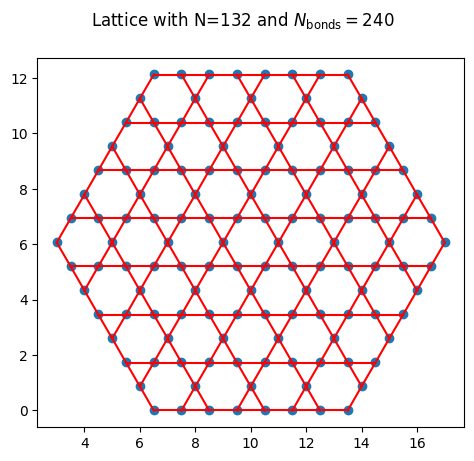

In [50]:
bonds_3nn = bonds._find_all_bonds(BZ_kpoints_cut[:, :], 1.1)
fig, ax = plt.subplots(1,1)
# my_x, my_y = zip((np.stack(BZ_kpoints_cut, 0)[:, 0], np.stack(BZ_kpoints_cut, 0)[:, 1]))
ax.scatter(my_x, my_y)
ax.set_aspect("equal")
plot_utils._plot_v_bonds(ax, bonds_3nn, c='r')
fig.suptitle(f"Lattice with N={my_x[0].shape[0]} and " +r"$N_{\rm bonds}=$" + f"{bonds_3nn.shape[0]}")


In [51]:
bonds_3nn.shape

(240, 2, 2)

In [52]:
bonds_nn.shape

(240, 2, 2)

#### Saddle point 

In [53]:
bonds_dict = utils.build_dict_bonds(bonds_nn)

In [54]:
list(bonds_dict.keys())[0]

'[[6.5 0. ]\n [7.5 0. ]]'

In [55]:
couplings = {'alpha':1, "beta":-2, "K":-0.5}
Q_init = np.ones(len(bonds_nn))
Q0 = 1 # this should always be set as one, original idea is to start with a smaller scale of Q0, but this is not 
        # what's been implemented. TODO: fix this. 
# energy_Q = lambda Q_init: utils.get_energy(couplings, Q_init, Q0, ListEBs, bonds_dict)
energy_Q = lambda Q_init: utils.get_energy_rydberg(couplings, Q_init, Q0, ListEBs, ryd_bonds, bonds_dict)


In [56]:
linear_constraint = LinearConstraint(np.diag(Q_init), np.zeros_like(Q_init), 5 * np.ones_like(Q_init))
results_gs = minimize(energy_Q, Q_init, method='trust-constr',
               constraints=linear_constraint,
               options={'verbose': 1})
# results_gs = minimize(energy_Q, Q_init)

`gtol` termination condition is satisfied.
Number of iterations: 300, function evaluations: 71095, CG iterations: 1576, optimality: 6.22e-10, constraint violation: 0.00e+00, execution time: 4.9e+03 s.


In [57]:
time_today = datetime.today().strftime('%Y-%m-%d')
pickle.dump(results_gs, open(f"results_gs_ryd_{time_today}.p", "wb"))

In [58]:
print(results_gs['fun'])
print(results_gs['success'])
print(results_gs['message'])
print(results_gs['status'])
results_gs['x']

-1424.9951537296886
True
`gtol` termination condition is satisfied.
1


array([4.99999670e+00, 8.20707605e-04, 5.74920330e-04, 5.75067095e-04,
       4.99999670e+00, 4.99999670e+00, 5.75097222e-04, 5.74775502e-04,
       8.21446812e-04, 8.20191695e-04, 8.21974348e-04, 4.99999670e+00,
       8.21498564e-04, 5.75037624e-04, 5.75236954e-04, 8.21685253e-04,
       5.75210251e-04, 4.99999670e+00, 8.21973441e-04, 5.75239546e-04,
       5.74976763e-04, 4.99999670e+00, 5.75238436e-04, 4.99999670e+00,
       5.75154587e-04, 8.21623542e-04, 5.75210258e-04, 4.99999670e+00,
       5.75209600e-04, 8.21860475e-04, 5.74806460e-04, 4.99999670e+00,
       5.75010336e-04, 4.99999670e+00, 5.75212038e-04, 5.75265867e-04,
       5.75236732e-04, 5.74770938e-04, 4.99999670e+00, 5.74744521e-04,
       5.75067513e-04, 5.74618855e-04, 4.99999670e+00, 8.21562454e-04,
       5.74586432e-04, 5.74980855e-04, 5.75137344e-04, 8.21623732e-04,
       4.99999670e+00, 8.19855980e-04, 8.21507527e-04, 8.21507521e-04,
       8.21446363e-04, 8.22034764e-04, 8.21448076e-04, 8.20312447e-04,
      

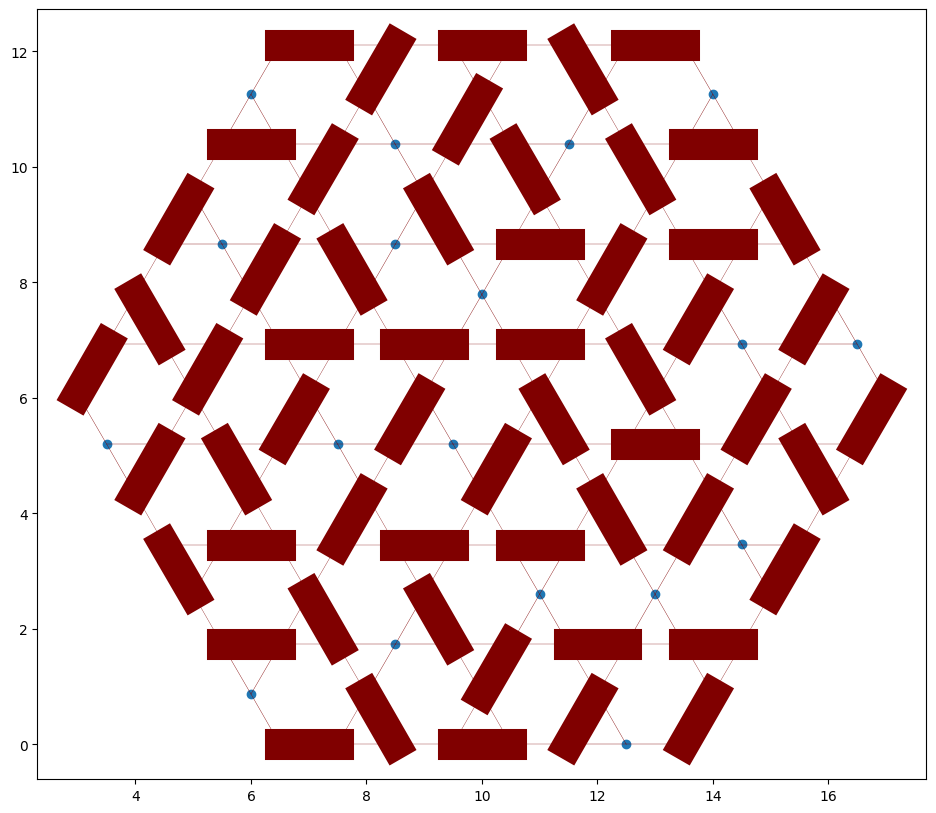

In [59]:
colors = plt.cm.jet(np.linspace(0,1,2))
fig, ax = plt.subplots(1,1, figsize=(16, 10))
ax.scatter(my_x, my_y)
for bond in [bonds_nn]:
  plot_utils._plot_visons(ax, bond, np.zeros_like(Q_init), Q_init * results_gs['x'], c=colors[((np.sign(results_gs['x']) + 1)/2).astype(int)], p=10)
  ax.set_aspect("equal")
  ax.annotate(r"$\bar{Q}^0=$" + f"{np.mean(results_gs['x']):.2f}", (2., 5.5), size=25)
  # ax.annotate(f"thickness" + r"$\sim \sqrt{||Q^0_{ij}| - |Q^v_{ij}||}$", (1.5, 4.5), color='r', size = 15)
  # ax.annotate(r"$Q^0_{ij} - Q^v_{ij}$", (0., 1.25), color='r')

#### vison pairs


In [60]:

# visonSpecs = bonds.Visons(
#     v_pt=np.array([7, 5 * height]),
#     visonBonds_vs = [np.array([[7.5, 4 * height], [8., 5 * height]]),
#                  np.array([[7.5, 4 * height], [8.5, 4. * height]]), 
#               np.array([[8.5, 4. * height], [9.,  3 * height]]), 
#               np.array([[9.,  3 * height], [9.5, 4 *height]]), 
#               np.array([[10.5, 2 *height], [11, 3 * height]]),
#               ]
# )              
visonSpecs = bonds.Visons(
    # v_pt=np.array([11, 19/3 * height]),
    v_pt=np.array([[11, 8],[5 * height, 25/3 * height]]),
    visonBonds_vs = [
                 np.array([[7.5, 8 * height], [8.5, 8. * height]]), 
              np.array([[8.5, 8. * height], [9.,  7 * height]]), 
              np.array([[9.,  7 * height], [9.5, 8 *height]]), 
              np.array([[10.5, 6 *height], [11, 7 * height]]),
                     np.array([[10.5, 6 *height], [11.5, 6 * height]]),
              ]
)              
visonBonds_idx = []
# print(f"initial value of Q_init is {Q_init}")
Q_flip = copy.copy(Q_init)
for bd_v in visonSpecs.visonBonds_vs:
  bd_v = np.around (bd_v, 2)
  idx = bonds_dict[str(bd_v)]
  Q_flip[idx] = -1
  visonBonds_idx.append(idx)

# print(f"final value of Q_init is {Q_init}")

In [61]:
Q_init

array([1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
       1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
       1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
       1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
       1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
       1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
       1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
       1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
       1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
       1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
       1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
       1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
       1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
       1., 1., 1., 1., 1.

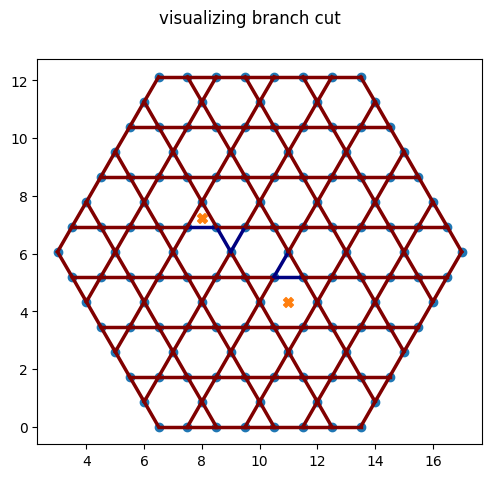

In [62]:
colors = plt.cm.jet(np.linspace(0,1,2))
fig, ax = plt.subplots(1,1, figsize=(8, 5))
ax.scatter(my_x, my_y)
# Q_flip = Q_init
# print(Q_init)
for bond in [bonds_nn]:
  plot_utils._plot_visons(ax, bond, np.zeros_like(Q_flip), Q_flip, c=colors[((Q_flip + 1)/2).astype(int)], p=2.5)
  ax.scatter(*visonSpecs.v_pt, marker="X", s=50.)
  ax.set_aspect("equal")
  ax.annotate(r"$Q^0=$" + f"{results_gs['x'][0]:.2f}", (0., 2.5))
  # ax.annotate(r"$Q^0_{ij} - Q^v_{ij}$", (0., 1.25), color='r')
  plt.suptitle("visualizing branch cut")

In [63]:
results_gs['x']

array([4.99999670e+00, 8.20707605e-04, 5.74920330e-04, 5.75067095e-04,
       4.99999670e+00, 4.99999670e+00, 5.75097222e-04, 5.74775502e-04,
       8.21446812e-04, 8.20191695e-04, 8.21974348e-04, 4.99999670e+00,
       8.21498564e-04, 5.75037624e-04, 5.75236954e-04, 8.21685253e-04,
       5.75210251e-04, 4.99999670e+00, 8.21973441e-04, 5.75239546e-04,
       5.74976763e-04, 4.99999670e+00, 5.75238436e-04, 4.99999670e+00,
       5.75154587e-04, 8.21623542e-04, 5.75210258e-04, 4.99999670e+00,
       5.75209600e-04, 8.21860475e-04, 5.74806460e-04, 4.99999670e+00,
       5.75010336e-04, 4.99999670e+00, 5.75212038e-04, 5.75265867e-04,
       5.75236732e-04, 5.74770938e-04, 4.99999670e+00, 5.74744521e-04,
       5.75067513e-04, 5.74618855e-04, 4.99999670e+00, 8.21562454e-04,
       5.74586432e-04, 5.74980855e-04, 5.75137344e-04, 8.21623732e-04,
       4.99999670e+00, 8.19855980e-04, 8.21507527e-04, 8.21507521e-04,
       8.21446363e-04, 8.22034764e-04, 8.21448076e-04, 8.20312447e-04,
      

In [64]:
couplings = {'alpha':1, "beta":-2, "K":-0.5}
Q_init_vs = copy.copy(results_gs['x'])
Q0 = 1 # this should always be set as one, original idea is to start with a smaller scale of Q0, but this is not 
        # what's been implemented. TODO: fix this. 
for idx in visonBonds_idx:
  Q_init_vs[idx] = -1 * Q_init_vs[idx]
energy_Q = lambda Q_init_vs: utils.get_energy_rydberg(couplings, Q_init_vs, Q0, ListEBs, ryd_bonds,bonds_dict)
linear_constraint = LinearConstraint(np.diag(Q_flip), np.zeros_like(Q_init_vs),  5 * np.ones_like(Q_init_vs))
results_vison = minimize(energy_Q, Q_init_vs, method='trust-constr',
               constraints=linear_constraint,
               options={'verbose': 1})
# results_vison = minimize(energy_Q, Q_init, bounds=einops.repeat(np.array([-10, 5]), 'a -> r a', r=len(Q_init)), options={'maxiter':1}, method="CG")

`gtol` termination condition is satisfied.
Number of iterations: 21, function evaluations: 3856, CG iterations: 26, optimality: 5.47e-10, constraint violation: 0.00e+00, execution time: 2.4e+02 s.


In [65]:
energy_Q(Q_init)

387.5

In [66]:
print(results_vison['fun'])
print(results_vison['success'])
print(results_vison['message'])
print(results_vison['status'])
results_vison['x']

-1424.9951198442761
True
`gtol` termination condition is satisfied.
1


array([ 4.99999662e+00,  8.23926051e-04,  5.72161469e-04,  5.72161514e-04,
        4.99999662e+00,  4.99999662e+00,  5.72247862e-04,  5.72247825e-04,
        8.24377337e-04,  8.23810603e-04,  8.24266042e-04,  4.99999662e+00,
        8.24491189e-04,  5.72161508e-04,  5.72247831e-04,  8.23750902e-04,
        5.72161511e-04,  4.99999662e+00,  8.24651995e-04,  5.72161684e-04,
        5.72161682e-04,  4.99999662e+00,  5.72247862e-04,  4.99999662e+00,
        5.72161510e-04,  8.23697530e-04,  5.72161669e-04,  4.99999662e+00,
        5.72161470e-04,  8.23751365e-04,  5.72247825e-04,  4.99999662e+00,
        5.72161503e-04,  4.99999662e+00,  5.72161669e-04,  5.72161301e-04,
        5.72161446e-04,  5.72161476e-04,  4.99999662e+00,  5.72248039e-04,
        5.72161481e-04,  5.72161511e-04,  4.99999662e+00,  8.24376132e-04,
        5.72161476e-04,  5.72161477e-04,  5.71978192e-04,  8.23751903e-04,
        4.99999662e+00,  8.22683205e-04,  8.22851935e-04,  8.22734504e-04,
        8.22601567e-04,  

In [67]:
time_today = datetime.today().strftime('%Y-%m-%d')
pickle.dump(results_vison, open(f"results_vison_pair_ryd_{time_today}.p", "wb"))

In [68]:
Q_init

array([1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
       1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
       1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
       1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
       1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
       1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
       1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
       1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
       1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
       1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
       1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
       1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
       1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
       1., 1., 1., 1., 1.

In [69]:
results_gs['x']

array([4.99999670e+00, 8.20707605e-04, 5.74920330e-04, 5.75067095e-04,
       4.99999670e+00, 4.99999670e+00, 5.75097222e-04, 5.74775502e-04,
       8.21446812e-04, 8.20191695e-04, 8.21974348e-04, 4.99999670e+00,
       8.21498564e-04, 5.75037624e-04, 5.75236954e-04, 8.21685253e-04,
       5.75210251e-04, 4.99999670e+00, 8.21973441e-04, 5.75239546e-04,
       5.74976763e-04, 4.99999670e+00, 5.75238436e-04, 4.99999670e+00,
       5.75154587e-04, 8.21623542e-04, 5.75210258e-04, 4.99999670e+00,
       5.75209600e-04, 8.21860475e-04, 5.74806460e-04, 4.99999670e+00,
       5.75010336e-04, 4.99999670e+00, 5.75212038e-04, 5.75265867e-04,
       5.75236732e-04, 5.74770938e-04, 4.99999670e+00, 5.74744521e-04,
       5.75067513e-04, 5.74618855e-04, 4.99999670e+00, 8.21562454e-04,
       5.74586432e-04, 5.74980855e-04, 5.75137344e-04, 8.21623732e-04,
       4.99999670e+00, 8.19855980e-04, 8.21507527e-04, 8.21507521e-04,
       8.21446363e-04, 8.22034764e-04, 8.21448076e-04, 8.20312447e-04,
      

In [70]:
Q0_results = results_gs['x']
Qv_results = results_vison['x']

In [71]:
Q0_results

array([4.99999670e+00, 8.20707605e-04, 5.74920330e-04, 5.75067095e-04,
       4.99999670e+00, 4.99999670e+00, 5.75097222e-04, 5.74775502e-04,
       8.21446812e-04, 8.20191695e-04, 8.21974348e-04, 4.99999670e+00,
       8.21498564e-04, 5.75037624e-04, 5.75236954e-04, 8.21685253e-04,
       5.75210251e-04, 4.99999670e+00, 8.21973441e-04, 5.75239546e-04,
       5.74976763e-04, 4.99999670e+00, 5.75238436e-04, 4.99999670e+00,
       5.75154587e-04, 8.21623542e-04, 5.75210258e-04, 4.99999670e+00,
       5.75209600e-04, 8.21860475e-04, 5.74806460e-04, 4.99999670e+00,
       5.75010336e-04, 4.99999670e+00, 5.75212038e-04, 5.75265867e-04,
       5.75236732e-04, 5.74770938e-04, 4.99999670e+00, 5.74744521e-04,
       5.75067513e-04, 5.74618855e-04, 4.99999670e+00, 8.21562454e-04,
       5.74586432e-04, 5.74980855e-04, 5.75137344e-04, 8.21623732e-04,
       4.99999670e+00, 8.19855980e-04, 8.21507527e-04, 8.21507521e-04,
       8.21446363e-04, 8.22034764e-04, 8.21448076e-04, 8.20312447e-04,
      

In [72]:
Q_init_vs

array([ 4.99999670e+00,  8.20707605e-04,  5.74920330e-04,  5.75067095e-04,
        4.99999670e+00,  4.99999670e+00,  5.75097222e-04,  5.74775502e-04,
        8.21446812e-04,  8.20191695e-04,  8.21974348e-04,  4.99999670e+00,
        8.21498564e-04,  5.75037624e-04,  5.75236954e-04,  8.21685253e-04,
        5.75210251e-04,  4.99999670e+00,  8.21973441e-04,  5.75239546e-04,
        5.74976763e-04,  4.99999670e+00,  5.75238436e-04,  4.99999670e+00,
        5.75154587e-04,  8.21623542e-04,  5.75210258e-04,  4.99999670e+00,
        5.75209600e-04,  8.21860475e-04,  5.74806460e-04,  4.99999670e+00,
        5.75010336e-04,  4.99999670e+00,  5.75212038e-04,  5.75265867e-04,
        5.75236732e-04,  5.74770938e-04,  4.99999670e+00,  5.74744521e-04,
        5.75067513e-04,  5.74618855e-04,  4.99999670e+00,  8.21562454e-04,
        5.74586432e-04,  5.74980855e-04,  5.75137344e-04,  8.21623732e-04,
        4.99999670e+00,  8.19855980e-04,  8.21507527e-04,  8.21507521e-04,
        8.21446363e-04,  

Text(0.5, 0.98, 'Visualizing signs of $Q_v$')

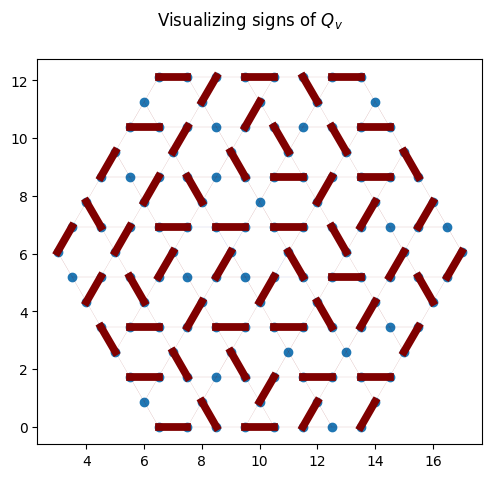

In [73]:
colors = plt.cm.jet(np.linspace(0,1,2))
fig, ax = plt.subplots(1,1, figsize=(8, 5))
ax.scatter(my_x, my_y)
for bond in [bonds_nn]:
  plot_utils._plot_visons(ax, bond, np.zeros_like(Qv_results), Qv_results, c=colors[((np.sign(Qv_results) + 1)/2).astype(int)], p=2.5)
  ax.set_aspect("equal")
  # ax.annotate(r"$Q^0=$" + f"{results_gs['x'][0]:.2f}", (0., 2.5))
  # ax.annotate(r"$Q^0_{ij} - Q^v_{ij}$", (0., 1.25), color='r')
plt.suptitle(f"Visualizing signs of $Q_v$")  

In [74]:
Qv_results - Q0_results

array([-8.16990733e-08,  3.21844592e-06, -2.75886114e-06, -2.90558155e-06,
       -8.17032166e-08, -8.16860020e-08, -2.84936000e-06, -2.52767744e-06,
        2.93052586e-06,  3.61890855e-06,  2.29169437e-06, -8.16764816e-08,
        2.99262532e-06, -2.87611550e-06, -2.98912274e-06,  2.06564945e-06,
       -3.04873995e-06, -8.17067756e-08,  2.67855397e-06, -3.07786197e-06,
       -2.81508104e-06, -8.17056138e-08, -2.99057442e-06, -8.17010193e-08,
       -2.99307692e-06,  2.07398776e-06, -3.04858880e-06, -8.17087944e-08,
       -3.04813047e-06,  1.89089076e-06, -2.55863550e-06, -8.16851671e-08,
       -2.84883294e-06, -8.16312342e-08, -3.05036946e-06, -3.10456547e-06,
       -3.07528625e-06, -2.60946214e-06, -8.16051990e-08, -2.49648191e-06,
       -2.90603236e-06, -2.45734362e-06, -8.17069559e-08,  2.81367766e-06,
       -2.42495574e-06, -2.81937794e-06, -3.15915270e-06,  2.12817046e-06,
       -8.16111347e-08,  2.82722435e-06,  1.34440807e-06,  1.22698361e-06,
        1.15520421e-06,  

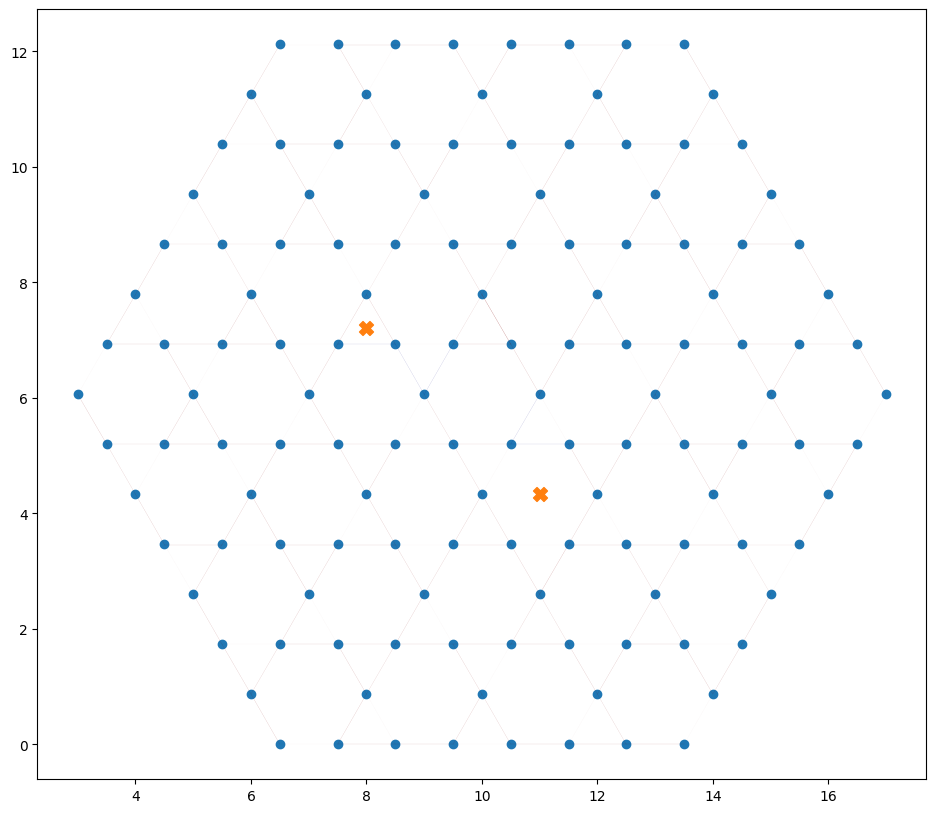

In [75]:
colors = plt.cm.jet(np.linspace(0,1,2))
fig, ax = plt.subplots(1,1, figsize=(16, 10))
ax.scatter(my_x, my_y)
for bond in [bonds_nn]:
  plot_utils._plot_visons(ax, bond, Q0_results, Q_flip * Qv_results, c=colors[((np.sign(Qv_results) + 1)/2).astype(int)], p=30)
  ax.scatter(*visonSpecs.v_pt, marker="X", s=100)
  ax.set_aspect("equal")
  ax.annotate(r"$Q^0=$" + f"{results_gs['x'][0]:.2f}", (2., 5.5), size=25)
  ax.annotate(f"thickness" + r"$\sim \sqrt{|Q^0_{ij} - Q^v_{ij}|}$", (1.5, 4.5), color='r', size = 15)
  ax.annotate(r"$Q^0_{ij} - Q^v_{ij}$", (0., 1.25), color='r')

#### vison


In [76]:

# visonSpecs = bonds.Visons(
#     v_pt=np.array([7, 5 * height]),
#     visonBonds_vs = [np.array([[7.5, 4 * height], [8., 5 * height]]),
#                  np.array([[7.5, 4 * height], [8.5, 4. * height]]), 
#               np.array([[8.5, 4. * height], [9.,  3 * height]]), 
#               np.array([[9.,  3 * height], [9.5, 4 *height]]), 
#               np.array([[10.5, 2 *height], [11, 3 * height]]),
#               ]
# )              
visonSpecs = bonds.Visons(
    v_pt=np.array([10, 7 * height]),
    visonBonds_vs = [np.array([[10.5, 6 * height], [11., 7 * height]]),
                 np.array([[10.5, 6 * height], [11.5, 6. * height]]), 
              np.array([[11.5, 6. * height], [12.,  5 * height]]), 
              np.array([[12.,  5 * height], [12.5, 6 *height]]), 
              np.array([[13.5, 4 *height], [14, 5 * height]]),
                     np.array([[13.5, 4 *height], [14.5, 4 * height]]),
              ]
)              
visonBonds_idx = []
print(f"initial value of Q_init is {Q_init}")
Q_flip = copy.copy(Q_init)
for bd_v in visonSpecs.visonBonds_vs:
  bd_v = np.around (bd_v, 2)
  idx = bonds_dict[str(bd_v)]
  Q_flip[idx] = -1
  visonBonds_idx.append(idx)

print(f"final value of Q_init is {Q_init}")

initial value of Q_init is [1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.
 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.
 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.
 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.
 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.
 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.
 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.
 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.
 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.
 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.]
final value of Q_init is [1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.
 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.
 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1

In [77]:
Q_init

array([1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
       1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
       1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
       1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
       1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
       1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
       1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
       1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
       1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
       1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
       1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
       1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
       1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
       1., 1., 1., 1., 1.

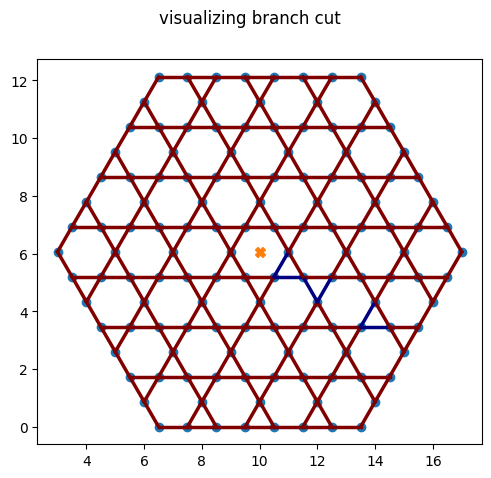

In [78]:
colors = plt.cm.jet(np.linspace(0,1,2))
fig, ax = plt.subplots(1,1, figsize=(8, 5))
ax.scatter(my_x, my_y)
# Q_flip = Q_init
# print(Q_init)
for bond in [bonds_nn]:
  plot_utils._plot_visons(ax, bond, np.zeros_like(Q_flip), Q_flip, c=colors[((Q_flip + 1)/2).astype(int)], p=2.5)
  ax.scatter(*visonSpecs.v_pt, marker="X", s=50.)
  ax.set_aspect("equal")
  ax.annotate(r"$Q^0=$" + f"{results_gs['x'][0]:.2f}", (0., 2.5))
  # ax.annotate(r"$Q^0_{ij} - Q^v_{ij}$", (0., 1.25), color='r')
  plt.suptitle("visualizing branch cut")

In [79]:
results_gs['x']

array([4.99999670e+00, 8.20707605e-04, 5.74920330e-04, 5.75067095e-04,
       4.99999670e+00, 4.99999670e+00, 5.75097222e-04, 5.74775502e-04,
       8.21446812e-04, 8.20191695e-04, 8.21974348e-04, 4.99999670e+00,
       8.21498564e-04, 5.75037624e-04, 5.75236954e-04, 8.21685253e-04,
       5.75210251e-04, 4.99999670e+00, 8.21973441e-04, 5.75239546e-04,
       5.74976763e-04, 4.99999670e+00, 5.75238436e-04, 4.99999670e+00,
       5.75154587e-04, 8.21623542e-04, 5.75210258e-04, 4.99999670e+00,
       5.75209600e-04, 8.21860475e-04, 5.74806460e-04, 4.99999670e+00,
       5.75010336e-04, 4.99999670e+00, 5.75212038e-04, 5.75265867e-04,
       5.75236732e-04, 5.74770938e-04, 4.99999670e+00, 5.74744521e-04,
       5.75067513e-04, 5.74618855e-04, 4.99999670e+00, 8.21562454e-04,
       5.74586432e-04, 5.74980855e-04, 5.75137344e-04, 8.21623732e-04,
       4.99999670e+00, 8.19855980e-04, 8.21507527e-04, 8.21507521e-04,
       8.21446363e-04, 8.22034764e-04, 8.21448076e-04, 8.20312447e-04,
      

In [80]:
couplings = {'alpha':1, "beta":-2, "K":-0.5}
Q_init_vs = copy.copy(results_gs['x'])
Q0 = 1 # this should always be set as one, original idea is to start with a smaller scale of Q0, but this is not 
        # what's been implemented. TODO: fix this. 
for idx in visonBonds_idx:
  Q_init_vs[idx] = -1 * Q_init_vs[idx]
energy_Q = lambda Q_init_vs: utils.get_energy_rydberg(couplings, Q_init_vs, Q0, ListEBs, ryd_bonds, bonds_dict)
linear_constraint = LinearConstraint(np.diag(Q_flip), np.zeros_like(Q_init_vs),  5 * np.ones_like(Q_init_vs))
results_vison = minimize(energy_Q, Q_init_vs, method='trust-constr',
               constraints=linear_constraint,
               options={'verbose': 1})
# results_vison = minimize(energy_Q, Q_init, bounds=einops.repeat(np.array([-10, 5]), 'a -> r a', r=len(Q_init)), options={'maxiter':1}, method="CG")

`gtol` termination condition is satisfied.
Number of iterations: 21, function evaluations: 3856, CG iterations: 26, optimality: 5.49e-10, constraint violation: 0.00e+00, execution time: 2.4e+02 s.


In [81]:
Q_init

array([1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
       1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
       1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
       1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
       1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
       1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
       1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
       1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
       1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
       1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
       1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
       1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
       1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
       1., 1., 1., 1., 1.

In [82]:
results_gs['x']

array([4.99999670e+00, 8.20707605e-04, 5.74920330e-04, 5.75067095e-04,
       4.99999670e+00, 4.99999670e+00, 5.75097222e-04, 5.74775502e-04,
       8.21446812e-04, 8.20191695e-04, 8.21974348e-04, 4.99999670e+00,
       8.21498564e-04, 5.75037624e-04, 5.75236954e-04, 8.21685253e-04,
       5.75210251e-04, 4.99999670e+00, 8.21973441e-04, 5.75239546e-04,
       5.74976763e-04, 4.99999670e+00, 5.75238436e-04, 4.99999670e+00,
       5.75154587e-04, 8.21623542e-04, 5.75210258e-04, 4.99999670e+00,
       5.75209600e-04, 8.21860475e-04, 5.74806460e-04, 4.99999670e+00,
       5.75010336e-04, 4.99999670e+00, 5.75212038e-04, 5.75265867e-04,
       5.75236732e-04, 5.74770938e-04, 4.99999670e+00, 5.74744521e-04,
       5.75067513e-04, 5.74618855e-04, 4.99999670e+00, 8.21562454e-04,
       5.74586432e-04, 5.74980855e-04, 5.75137344e-04, 8.21623732e-04,
       4.99999670e+00, 8.19855980e-04, 8.21507527e-04, 8.21507521e-04,
       8.21446363e-04, 8.22034764e-04, 8.21448076e-04, 8.20312447e-04,
      

In [83]:
energy_Q(Q_init)

387.5

In [84]:
print(results_vison['fun'])
print(results_vison['success'])
print(results_vison['message'])
print(results_vison['status'])
results_vison['x']

-1424.9951194528953
True
`gtol` termination condition is satisfied.
1


array([ 4.99999662e+00,  8.23920848e-04,  5.72220891e-04,  5.72220898e-04,
        4.99999662e+00,  4.99999662e+00,  5.72220767e-04,  5.72220733e-04,
        8.24487313e-04,  8.23923003e-04,  8.24376544e-04,  4.99999662e+00,
        8.24487620e-04,  5.72220721e-04,  5.72220942e-04,  8.23809097e-04,
        5.72220932e-04,  4.99999662e+00,  8.24761493e-04,  5.72220864e-04,
        5.72220903e-04,  4.99999662e+00,  5.72220762e-04,  4.99999662e+00,
        5.72220933e-04,  8.23861425e-04,  5.72220931e-04,  4.99999662e+00,
        5.72220935e-04,  8.23920778e-04,  5.72220733e-04,  4.99999662e+00,
        5.72220929e-04,  4.99999662e+00,  5.72220931e-04,  5.72220926e-04,
        5.72220910e-04,  5.72220899e-04,  4.99999662e+00,  5.72220700e-04,
        5.72220898e-04,  5.72220933e-04,  4.99999662e+00,  8.24487572e-04,
        5.72220716e-04,  5.72220897e-04,  5.71884574e-04,  8.23808015e-04,
        4.99999662e+00, -8.23023449e-04,  8.23024038e-04,  8.23089876e-04,
        8.22605601e-04,  

In [85]:
time_today = datetime.today().strftime('%Y-%m-%d')
pickle.dump(results_vison, open(f"results_vison_ryd_{time_today}.p", "wb"))

In [86]:
Q0_results = results_gs['x']
Qv_results = results_vison['x']

In [87]:
Q0_results

array([4.99999670e+00, 8.20707605e-04, 5.74920330e-04, 5.75067095e-04,
       4.99999670e+00, 4.99999670e+00, 5.75097222e-04, 5.74775502e-04,
       8.21446812e-04, 8.20191695e-04, 8.21974348e-04, 4.99999670e+00,
       8.21498564e-04, 5.75037624e-04, 5.75236954e-04, 8.21685253e-04,
       5.75210251e-04, 4.99999670e+00, 8.21973441e-04, 5.75239546e-04,
       5.74976763e-04, 4.99999670e+00, 5.75238436e-04, 4.99999670e+00,
       5.75154587e-04, 8.21623542e-04, 5.75210258e-04, 4.99999670e+00,
       5.75209600e-04, 8.21860475e-04, 5.74806460e-04, 4.99999670e+00,
       5.75010336e-04, 4.99999670e+00, 5.75212038e-04, 5.75265867e-04,
       5.75236732e-04, 5.74770938e-04, 4.99999670e+00, 5.74744521e-04,
       5.75067513e-04, 5.74618855e-04, 4.99999670e+00, 8.21562454e-04,
       5.74586432e-04, 5.74980855e-04, 5.75137344e-04, 8.21623732e-04,
       4.99999670e+00, 8.19855980e-04, 8.21507527e-04, 8.21507521e-04,
       8.21446363e-04, 8.22034764e-04, 8.21448076e-04, 8.20312447e-04,
      

Text(0.5, 0.98, 'Visualizing signs of $Q_v$')

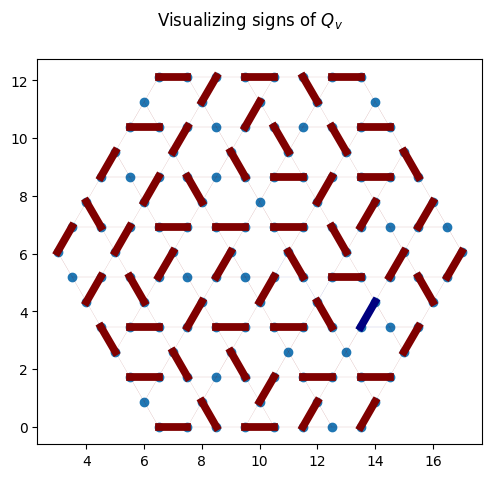

In [88]:
colors = plt.cm.jet(np.linspace(0,1,2))
fig, ax = plt.subplots(1,1, figsize=(8, 5))
ax.scatter(my_x, my_y)
for bond in [bonds_nn]:
  plot_utils._plot_visons(ax, bond, np.zeros_like(Qv_results), Qv_results, c=colors[((np.sign(Qv_results) + 1)/2).astype(int)], p=2.5)
  ax.set_aspect("equal")
  # ax.annotate(r"$Q^0=$" + f"{results_gs['x'][0]:.2f}", (0., 2.5))
  # ax.annotate(r"$Q^0_{ij} - Q^v_{ij}$", (0., 1.25), color='r')
plt.suptitle(f"Visualizing signs of $Q_v$")  

In [89]:
Qv_results - Q0_results

array([-8.20650508e-08,  3.21324321e-06, -2.69943873e-06, -2.84619682e-06,
       -8.20684471e-08, -8.20530559e-08, -2.87645583e-06, -2.55476916e-06,
        3.04050095e-06,  3.73130813e-06,  2.40219586e-06, -8.20421890e-08,
        2.98905615e-06, -2.81690316e-06, -3.01601138e-06,  2.12384451e-06,
       -2.98931948e-06, -8.20730390e-08,  2.78805212e-06, -3.01868149e-06,
       -2.75586014e-06, -8.20708967e-08, -3.01767369e-06, -8.20667951e-08,
       -2.93365411e-06,  2.23788338e-06, -2.98932668e-06, -8.20740249e-08,
       -2.98866522e-06,  2.06030380e-06, -2.58572710e-06, -8.20534565e-08,
       -2.78940679e-06, -8.19953554e-08, -2.99110713e-06, -3.04494094e-06,
       -3.01582146e-06, -2.55003942e-06, -8.19715673e-08, -2.52382056e-06,
       -2.84661525e-06, -2.39792248e-06, -8.20720656e-08,  2.92511796e-06,
       -2.36571532e-06, -2.75995822e-06, -3.25277066e-06,  2.18428226e-06,
       -8.19788202e-08, -1.64287943e-03,  1.51651178e-06,  1.58235495e-06,
        1.15923810e-06,  

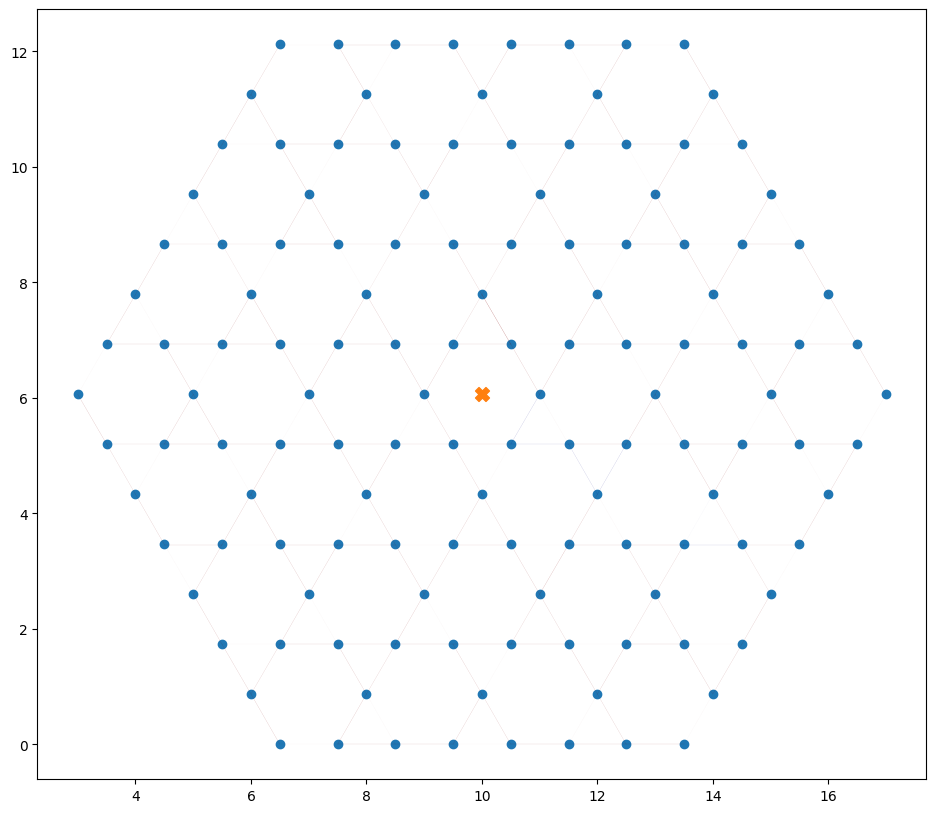

In [90]:
colors = plt.cm.jet(np.linspace(0,1,2))
fig, ax = plt.subplots(1,1, figsize=(16, 10))
ax.scatter(my_x, my_y)
for bond in [bonds_nn]:
  plot_utils._plot_visons(ax, bond, Q0_results, Q_flip * Qv_results, c=colors[((np.sign(Qv_results) + 1)/2).astype(int)], p=30)
  ax.scatter(*visonSpecs.v_pt, marker="X", s=100)
  ax.set_aspect("equal")
  ax.annotate(r"$Q^0=$" + f"{results_gs['x'][0]:.2f}", (2., 5.5), size=25)
  ax.annotate(f"thickness" + r"$\sim \sqrt{|Q^0_{ij} - Q^v_{ij}|}$", (1.5, 4.5), color='r', size = 15)
  ax.annotate(r"$Q^0_{ij} - Q^v_{ij}$", (0., 1.25), color='r')